In [ ]:
!pip install contractions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import contractions
import string
import keras
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from utilities import *

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

# get data

In [ ]:
df = pd.read_csv(root+'train_data.csv')
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [ ]:
df['contains_link'] = df['comment'].str.contains(r'http\S+', regex=True)
df['contains_hashtag'] = df['comment'].str.contains(r'#\w+', regex=True)
df['subreddit_mention'] = df['comment'].str.contains(r'\br/+', regex=True)
df['user_mention'] = df['comment'].str.contains(r'\bu/+', regex=True)

In [ ]:
# also check for capitalized words, emoticons, number of punctuation marks

In [ ]:
df[['contains_link', 'contains_hashtag', 'subreddit_mention', 'user_mention']].sum().div(df.shape[0]).mul(100)

contains_link        0.010190
contains_hashtag     0.370904
subreddit_mention    0.175905
user_mention         0.027306
dtype: float64

In [ ]:
df[['label', 'contains_link', 'contains_hashtag', 'subreddit_mention', 'user_mention']].groupby('label').sum()

,contains_link,contains_hashtag,subreddit_mention,user_mention
label,,,,
0,90,2090,1124,183
1,13,1659,654,93


what to delete, what to keep?

In [ ]:
df['comment'] = df['comment'].str.replace(r'http\S+', '', regex=True).str.replace(r'\bu/+', '', regex=True)

In [ ]:
X = df['comment'].apply(lambda x: contractions.fix(x))
y = df['label'].values

In [ ]:
glove_vocab = WordEmbeddings().get_glove_vocab()

In [ ]:
any([x.lower() != x for x in glove_vocab])

False

In [ ]:
not_alphanumeric = [x for x in glove_vocab if not x.isalnum()]

In [ ]:
not_alphanumeric

[',',
 '.',
 '"',
 "'s",
 '-',
 '(',
 ')',
 "''",
 '``',
 ':',
 "'",
 '--',
 "n't",
 '$',
 ';',
 '_',
 'u.s.',
 '?',
 '–',
 '%',
 "'re",
 '/',
 '...',
 "'ve",
 "'m",
 '&amp;',
 'u.n.',
 'inc.',
 "'ll",
 '’s',
 '!',
 'st.',
 'no.',
 '`',
 'corp.',
 "'d",
 '&',
 'co.',
 'p.m.',
 '=',
 '—',
 'dr.',
 'sept.',
 '“',
 '”',
 'w.',
 'a.m.',
 'sen.',
 '1,000',
 'c.',
 'mr.',
 'j.',
 'a.',
 'oct.',
 'dec.',
 'jr.',
 'jan.',
 'vs.',
 'nov.',
 'ms.',
 'm.',
 's.',
 '10,000',
 '1/2',
 'aug.',
 'gen.',
 '#',
 '.....',
 'rep.',
 'feb.',
 '[',
 '------',
 '6-3',
 '6-4',
 '2,000',
 'ltd.',
 '100,000',
 '’',
 'e.',
 'mrs.',
 '1.5',
 'b.',
 '+',
 '6-2',
 'gov.',
 '5,000',
 'h.',
 'd.',
 'd.c.',
 'r.',
 '3,000',
 'l.',
 'f.',
 '¥',
 'p.',
 '1-0',
 '2.5',
 '___',
 'calif.',
 '20,000',
 '2-1',
 '2-0',
 '50,000',
 'n.y.',
 '6-1',
 '1.2',
 'v.',
 '‘',
 'etc.',
 '£',
 '30,000',
 '7-6',
 'lt.',
 '200,000',
 'g.',
 '1,500',
 '10-year',
 '|',
 '4,000',
 '500,000',
 '1.3',
 '3.5',
 ']',
 't.',
 '3-0',
 'fla.',
 'e

In [ ]:
include_in_vocab = list(string.punctuation)

include_in_vocab.remove('-')
include_in_vocab.remove("'")

include_in_vocab.append("'s")
include_in_vocab.append("'ll")
# include_in_vocab.append('&amp;')

In [ ]:
# sent = pd.Series(['this is a SaMple sentence. 42 is the answer b4 the noon; but you knoww that 1.87', "semi-charmed student's should"])

In [ ]:
# for symbol in include_in_vocab:
#     sent = sent.str.replace(symbol, fr' {symbol} ', regex=False)

# sent = sent.str.replace(r'\d+', '', regex=True)
# sent.values[0]

'this is a SaMple sentence .   is the answer b the noon ;  but you knoww that  . '

In [ ]:
# tokenizer = Tokenizer(filters='')
# tokenizer.fit_on_texts(sent)
# tokenizer.word_index

{"'s": 16,
 '.': 2,
 ';': 9,
 'a': 4,
 'answer': 8,
 'but': 10,
 'is': 1,
 'knoww': 12,
 'sample': 5,
 'semi-charmed': 14,
 'sentence': 6,
 'should': 17,
 'student': 15,
 'that': 13,
 'the': 7,
 'this': 3,
 'you': 11}

In [ ]:
# should replace punctuation (but not "-") with version with spaces on both sides (don't know what to do with "." tho)
# and i don't know what to do with digits then, digits with commas and periods

In [ ]:
# maybe slang should not be dependent on X_train, but the regex should be "space or nothing" then

In [ ]:
# also interesting with the 'll, 's embeddings, this can be helpful
# but how to preserve these and add spaces around "'"? or how to delete "'" of not a part of these? or just leave "'" alone
# the tokenizer did not filter it out either

In [ ]:
# slang = pd.read_csv(root+'slang.csv', usecols=['acronym', 'expansion'])
# slang.drop_duplicates(inplace=True)
# slang.shape

(3250, 2)

In [ ]:
# slang.to_csv(root+'slang_no_duplicates.csv', index=False)

In [ ]:
slang = pd.read_csv(root+'slang_no_duplicates_manual.csv')
slang.shape

(2967, 2)

In [ ]:
slang[slang['acronym'].duplicated()].sort_values('acronym')['acronym']

Series([], Name: acronym, dtype: object)

In [ ]:
slang = slang[~slang['acronym'].isin(glove_vocab)].reset_index(drop=True)
slang.shape

(1405, 2)

In [ ]:
# slang = slang[slang['acronym'] != 'hawt'].drop_duplicates(subset='acronym', keep='last', inplace=False)

In [ ]:
slang_mapping = dict(list(slang.to_records(index=False)))
slang_mapping = {re.compile(r'\b{}\b'.format(k)): v for k, v in slang_mapping.items()}

In [ ]:
len(slang_mapping)

1405

In [ ]:
X = X.str.lower().replace(slang_mapping, regex=True)

In [ ]:
for symbol in include_in_vocab:
    X = X.str.replace(symbol, fr' {symbol} ', regex=False)

X = X.str.replace(r'\d+', '', regex=True)

In [ ]:
with open(root+'X', 'wb') as file:
    pickle.dump(X, file)

with open(root+'y', 'wb') as file:
    pickle.dump(y, file)

In [ ]:
X, y = pickle.load(open(root+'X', 'rb')), pickle.load(open(root+'y', 'rb'))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

In [ ]:
# X_train, X_val, X_test = [data.str.lower().replace(slang_mapping, regex=True) for data in [X_train, X_val, X_test]]

# tokenize

In [ ]:
input_dim = 10000
tokenizer = Tokenizer(num_words=input_dim, filters='')
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_val_tok = tokenizer.texts_to_sequences(X_val)
X_test_tok = tokenizer.texts_to_sequences(X_test)

In [ ]:
np.quantile([len(i) for i in X_train_tok], 0.9)

22.0

In [ ]:
maxlen = 20

In [ ]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_val_tok = pad_sequences(X_val_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

# embedding matrix

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer)

coverage: 0.9832


In [ ]:
not_covered = wordemb.words_not_covered()

In [ ]:
len(not_covered)

167

In [ ]:
not_covered[:50]

(('subreddit', 696),
 ('shitlord', 884),
 ('amirite', 927),
 ('downvote', 1040),
 ('downvoted', 1082),
 ('upvote', 1122),
 ('ayy', 1293),
 ('hahaha', 1562),
 ('downvotes', 1803),
 ('upvotes', 2008),
 ('circlejerk', 2057),
 ('redditors', 2280),
 ('upvoted', 2321),
 ('rekt', 2422),
 ('ftfy', 2473),
 ('skyrim', 2594),
 ('b-but', 2629),
 ('shitpost', 2652),
 ('redditor', 2832),
 ('wsgy', 2869),
 ('csgo', 2935),
 ('nbsp', 2978),
 ('nerfed', 3068),
 ('sjws', 3096),
 ('cuck', 3288),
 ('downvoting', 3335),
 ('dumbass', 3340),
 ('pleb', 3343),
 ('gtfo', 3371),
 ('damnit', 3376),
 ('b-b-but', 3380),
 ('sheeple', 3533),
 ('shits', 3654),
 ('hahahaha', 3825),
 ("fuckin'", 3889),
 ('cmon', 3943),
 ('shitting', 3989),
 ('pussies', 4122),
 ('hahahahaha', 4241),
 ('imgur', 4254),
 ('butthurt', 4317),
 ('fnaf', 4325),
 ('vape', 4429),
 ('neckbeard', 4475),
 ('subreddits', 4736),
 ("'murica", 4775),
 ('clickbait', 4812),
 ('noobs', 4908),
 ('amiright', 4974),
 ('brexit', 4987))

In [ ]:
# should map haha+ to haha or something

In [ ]:
# ftfy - fixed that for you
# sjws - social justice warriors

In [ ]:
df[df['comment'].str.contains('b-but')]

,label,comment,contains_link,contains_hashtag,subreddit_mention,user_mention
4837,1,B-b-but you don't pay their subscription!,False,False,False,False
5955,1,B-b-but it means something different to him,False,False,False,False
8416,1,"INB4 ""B-b-b-but muh rape statistics""",False,False,False,False
9706,1,B-b-but statistics are racist!,False,False,False,False
11011,1,B-b-but Julio Jones hands to the face!,False,False,False,False
...,...,...,...,...,...,...
993901,1,"B-b-b-but... Something, something, gun owners ...",False,False,False,False
995196,1,B-b-but I have Demonoid!,False,False,False,False
1003843,1,B-b-but if people won't get into debt then the...,False,False,False,False
1004897,1,B-b-b-but I thought Obama said it wouldn't aff...,False,False,False,False


In [ ]:
df[df['comment'].str.contains('b-but')]['label'].value_counts() # quite a strong indicator of sarcasm

1    346
0     21
Name: label, dtype: int64

In [ ]:
df[df['comment'].str.contains('amirite')]['label'].value_counts()

1    884
0    111
Name: label, dtype: int64

In [ ]:
df[df['comment'].str.contains('shitlord')]['label'].value_counts() # noicee

1    1012
0      85
Name: label, dtype: int64

# CNN + biLSTM

## sgd + vec_len = 100

In [ ]:
vec_len = 100
embedding_matrix = get_glove_embeddings(input_dim, vec_len)

coverage: 0.9757


In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=20, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(32, 5, activation='relu', padding='same'),
    Bidirectional(LSTM(5, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 168s 29ms/step - loss: 0.6047 - accuracy: 0.6655 - val_loss: 0.5822 - val_accuracy: 0.6899
Epoch 2/50
5686/5686 [==============================] - 164s 29ms/step - loss: 0.5735 - accuracy: 0.6965 - val_loss: 0.5663 - val_accuracy: 0.7020
Epoch 3/50
5686/5686 [==============================] - 164s 29ms/step - loss: 0.5617 - accuracy: 0.7067 - val_loss: 0.5614 - val_accuracy: 0.7067
Epoch 4/50
5686/5686 [==============================] - 164s 29ms/step - loss: 0.5534 - accuracy: 0.7142 - val_loss: 0.5570 - val_accuracy: 0.7111
Epoch 5/50
5686/5686 [==============================] - 164s 29ms/step - loss: 0.5468 - accuracy: 0.7193 - val_loss: 0.5549 - val_accuracy: 0.7129
Epoch 6/50
5686/5686 [==============================] - 163s 29ms/step - loss: 0.5413 - accuracy: 0.7231 - val_loss: 0.5557 - val_accuracy: 0.7105
Epoch 7/50
5686/5686 [==============================] - 163s 29ms/step - loss: 0.5362 - accuracy: 0.7276 - val_loss: 0

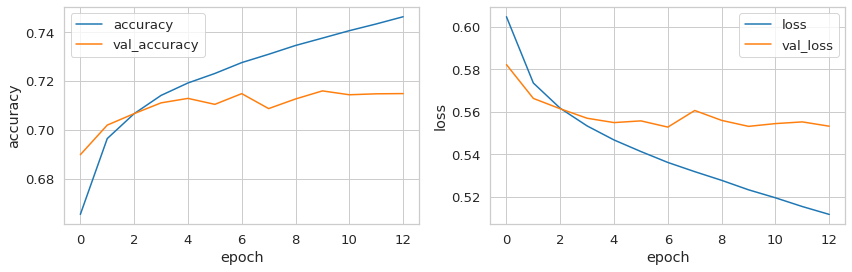

In [ ]:
plot_history(fit)

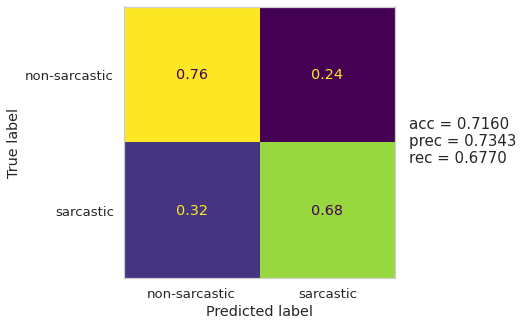

In [ ]:
evaluate(model, X_val, y_val)

In [ ]:
print(tokenizer.sequences_to_texts(X_train_tok[[0,9],:].tolist()))
print(y_train.values[[0,9]])

['you are a good christian', 'yeah i am sure that no religion means we will not hate each other anymore']
[1 1]


## sgd + vec_len = 50

In [ ]:
vec_len = 50
embedding_matrix = get_glove_embeddings(input_dim, vec_len)

coverage: 0.9757


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=20, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(32, 5, activation='relu', padding='same'),
    Bidirectional(LSTM(5, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
5686/5686 [==============================] - 458s 78ms/step - loss: 0.6139 - accuracy: 0.6552 - val_loss: 0.5896 - val_accuracy: 0.6814
Epoch 2/50
5686/5686 [==============================] - 358s 63ms/step - loss: 0.5811 - accuracy: 0.6895 - val_loss: 0.5757 - val_accuracy: 0.6949
Epoch 3/50
5686/5686 [==============================] - 354s 62ms/step - loss: 0.5689 - accuracy: 0.7009 - val_loss: 0.5685 - val_accuracy: 0.7015
Epoch 4/50
5686/5686 [==============================] - 350s 62ms/step - loss: 0.5607 - accuracy: 0.7081 - val_loss: 0.5648 - val_accuracy: 0.7043
Epoch 5/50
5686/5686 [==============================] - 347s 61ms/step - loss: 0.5535 - accuracy: 0.7141 - val_loss: 0.5616 - val_accuracy: 0.7079
Epoch 6/50
5686/5686 [==============================] - 347s 61ms/step - loss: 0.5483 - accuracy: 0.7182 - val_loss: 0.5630 - val_accuracy: 0.7084
Epoch 7/50
5686/5686 [==============================] - 348s 61ms/step - loss: 0.5439 - accuracy: 0.7218 - val_loss: 0

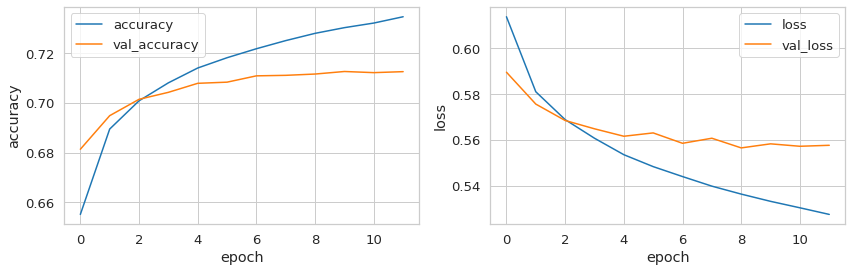

In [ ]:
plot_history(fit)

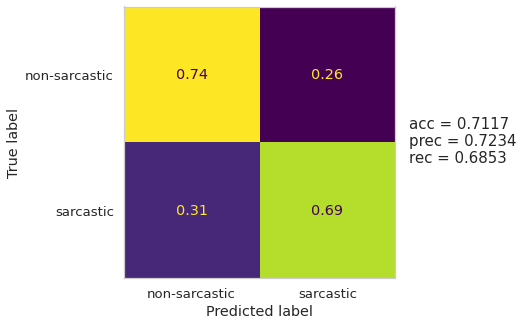

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, y_val, n=5)

False negatives
can lead to you might want to wipe that off
nice try us navy or should i say official american
it is for the greater good
about how many reps you do or the weight you move it is about how many likes you can get
wow you recorded this but did not take it upon yourself to grab a few paper to wipe the mirror

False positives
you should not comment if you do not understand how dangerous he is to safety
but it is still spelled
pretty sure you will see him on another soon enough
dank memes bro you get them from the tea party sub or you make this trash yourself
because they would not an nfl team for a missed field goal


In [ ]:
model.save(root+'cnn_bilstm_sgd')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_sgd/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_sgd/assets


## after better preprocessing

### normal embeddings

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer)

coverage: 0.9832


In [ ]:
# change to val_loss

In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(32, 3, activation='relu', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 343s 55ms/step - loss: 0.5606 - accuracy: 0.7077 - val_loss: 0.5425 - val_accuracy: 0.7234
Epoch 2/50
6002/6002 [==============================] - 323s 54ms/step - loss: 0.5251 - accuracy: 0.7363 - val_loss: 0.5334 - val_accuracy: 0.7290
Epoch 3/50
6002/6002 [==============================] - 332s 55ms/step - loss: 0.5056 - accuracy: 0.7508 - val_loss: 0.5406 - val_accuracy: 0.7267
Epoch 4/50
6002/6002 [==============================] - 329s 55ms/step - loss: 0.4866 - accuracy: 0.7640 - val_loss: 0.5366 - val_accuracy: 0.7315
Epoch 5/50
6002/6002 [==============================] - 325s 54ms/step - loss: 0.4676 - accuracy: 0.7769 - val_loss: 0.5448 - val_accuracy: 0.7291
Epoch 6/50
6002/6002 [==============================] - 333s 55ms/step - loss: 0.4481 - accuracy: 0.7900 - val_loss: 0.5550 - val_accuracy: 0.7256
Epoch 7/50
6002/6002 [==============================] - 332s 55ms/step - loss: 0.4283 - accuracy: 0.8022 - val_loss: 0

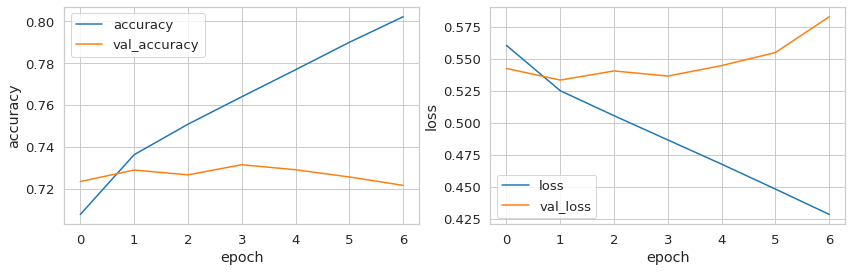

In [ ]:
plot_history(fit)

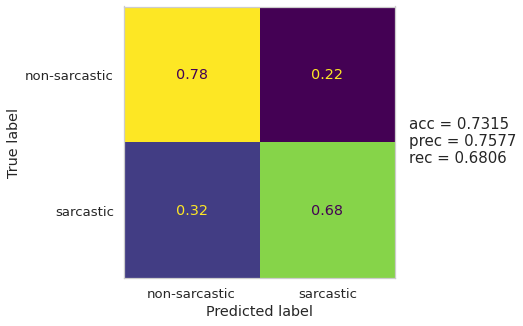

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, y_val, n=5)

False negatives:
---------------------------
i ordered a page from pelican and he raped me and his dick got soft . 
but you cannot  * seriously *  know what it is like until you have one of your own to love . 
i am sorry ,  but after the panama papers i do not find myself being attracted to her anymore . 
pretty sure it was the game developers . 
forgot etc ,  so have a downvote . 

False positives:
---------------------------
perhaps australia should send those who feel the need for sharia courts to places where there are sharia courts . 
yeah not really sure why ziplines do not have proper textures .  .  . 
think nick should invest in bike locks too after his track record of losing them
half-life  confirmed . 
 " teach women not to lie " 


In [ ]:
model.save(root+'cnn_bilstm_adam')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam/assets


## twitter embeddings

In [ ]:
vec_len = 50
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, twitter=True)

for twitter vec_len = 50
coverage: 0.9931


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[embedding_matrix], trainable=True),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(32, 3, activation='relu', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 596s 97ms/step - loss: 0.5608 - accuracy: 0.7074 - val_loss: 0.5390 - val_accuracy: 0.7252
Epoch 2/50
6002/6002 [==============================] - 614s 102ms/step - loss: 0.5276 - accuracy: 0.7344 - val_loss: 0.5328 - val_accuracy: 0.7295
Epoch 3/50
6002/6002 [==============================] - 595s 99ms/step - loss: 0.5114 - accuracy: 0.7461 - val_loss: 0.5349 - val_accuracy: 0.7298
Epoch 4/50
6002/6002 [==============================] - 612s 102ms/step - loss: 0.4969 - accuracy: 0.7566 - val_loss: 0.5384 - val_accuracy: 0.7306
Epoch 5/50
6002/6002 [==============================] - 610s 102ms/step - loss: 0.4829 - accuracy: 0.7668 - val_loss: 0.5426 - val_accuracy: 0.7294


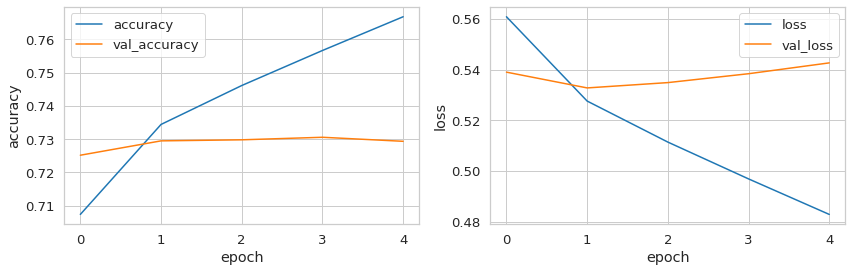

In [ ]:
plot_history(fit)

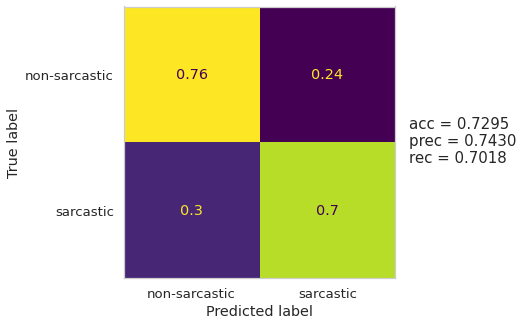

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(tokenizer, model, X_val, y_val, n=5)

False negatives:
---------------------------
i do not know about you ,  i did luge in my backyard all the time as a kid
raising a child to  costs about as much as med school ,  so they are pretty much the same . 
kwality
i believe your story  %  . 
you mean mobileme ? 

False positives:
---------------------------
are not hot and cold water pipes the same material ? 
draw childish pictures of penises on other people 's  personal property
challenger explosion . 
got to make the postseason first
they would just put the pictures up and we would all start jerking off as one nation under gawwwwd


In [ ]:
model.save(root+'cnn_bilstm_adam_twitter')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_bilstm_adam_twitter/assets


## freezing

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer)

coverage: 0.9832


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [ ]:
model = Sequential([
    embedding_layer,
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(32, 3, activation='relu', padding='same'),
    Bidirectional(LSTM(20, recurrent_dropout=0.5)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 336s 54ms/step - loss: 0.5946 - accuracy: 0.6765 - val_loss: 0.5755 - val_accuracy: 0.6951
Epoch 2/50
6002/6002 [==============================] - 321s 54ms/step - loss: 0.5673 - accuracy: 0.7007 - val_loss: 0.5649 - val_accuracy: 0.7029
Epoch 3/50
6002/6002 [==============================] - 321s 53ms/step - loss: 0.5593 - accuracy: 0.7076 - val_loss: 0.5616 - val_accuracy: 0.7055
Epoch 4/50
6002/6002 [==============================] - 317s 53ms/step - loss: 0.5545 - accuracy: 0.7119 - val_loss: 0.5603 - val_accuracy: 0.7074
Epoch 5/50
6002/6002 [==============================] - 327s 54ms/step - loss: 0.5514 - accuracy: 0.7145 - val_loss: 0.5603 - val_accuracy: 0.7089
Epoch 6/50
6002/6002 [==============================] - 313s 52ms/step - loss: 0.5491 - accuracy: 0.7167 - val_loss: 0.5566 - val_accuracy: 0.7111
Epoch 7/50
6002/6002 [==============================] - 313s 52ms/step - loss: 0.5467 - accuracy: 0.7180 - val_loss: 0

In [ ]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(1e-5)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=3)

Epoch 1/3
6002/6002 [==============================] - 325s 53ms/step - loss: 0.5397 - accuracy: 0.7238 - val_loss: 0.5533 - val_accuracy: 0.7135
Epoch 2/3
6002/6002 [==============================] - 309s 51ms/step - loss: 0.5369 - accuracy: 0.7259 - val_loss: 0.5521 - val_accuracy: 0.7147
Epoch 3/3
6002/6002 [==============================] - 321s 54ms/step - loss: 0.5351 - accuracy: 0.7274 - val_loss: 0.5513 - val_accuracy: 0.7153


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=3, callbacks=[es])

Epoch 1/3
6002/6002 [==============================] - 337s 56ms/step - loss: 0.5337 - accuracy: 0.7285 - val_loss: 0.5505 - val_accuracy: 0.7158
Epoch 2/3
6002/6002 [==============================] - 338s 56ms/step - loss: 0.5322 - accuracy: 0.7296 - val_loss: 0.5498 - val_accuracy: 0.7165
Epoch 3/3
6002/6002 [==============================] - 335s 56ms/step - loss: 0.5310 - accuracy: 0.7305 - val_loss: 0.5492 - val_accuracy: 0.7170


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, restore_best_weights=True)
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 351s 59ms/step - loss: 0.5298 - accuracy: 0.7314 - val_loss: 0.5486 - val_accuracy: 0.7174
Epoch 2/30
6002/6002 [==============================] - 348s 58ms/step - loss: 0.5287 - accuracy: 0.7323 - val_loss: 0.5482 - val_accuracy: 0.7180
Epoch 3/30
6002/6002 [==============================] - 351s 58ms/step - loss: 0.5276 - accuracy: 0.7331 - val_loss: 0.5477 - val_accuracy: 0.7184


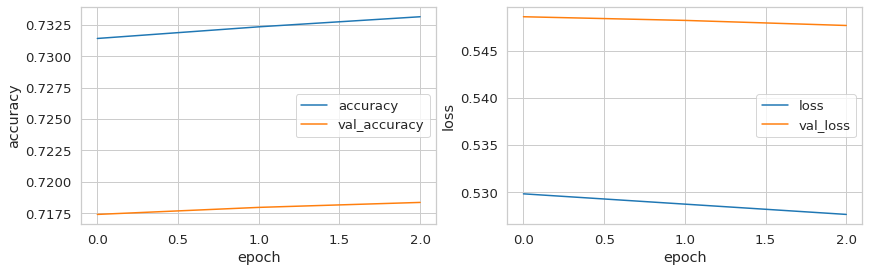

In [ ]:
plot_history(fit)

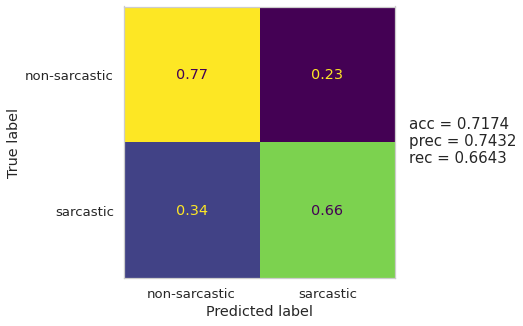

In [ ]:
evaluate(model, X_val_tok, y_val)